## Imports

In [2]:
import os
import h5py
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D, TimeDistributed, MaxPooling1D, Flatten
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay

from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from parse_data import load_intra_train, load_intra_test, load_cross_train, load_cross_test

## Constants

In [4]:
DOWNSAMPLING_STEP = 8
NUM_CLASSES = 4
BATCH_SIZE = 3

ENCODE_MAP = {
        'rest': 0,
        'motor': 1,
        'memory': 2,
        'math': 3,
    }

INTRA_OR_CROSS_MODE = "cross"

if INTRA_OR_CROSS_MODE == "cross":
    load_train = load_cross_train
    load_test = load_cross_test
elif INTRA_OR_CROSS_MODE == "intra":
    load_train = load_intra_train
    load_test = load_intra_test


## Load data

In [6]:
filenamepath_train = ("C:/Users/guill/Desktop/Uni/DeepLearning/Final Project data/Cross/train")
filenamepath_test = ("C:/Users/guill/Desktop/Uni/DeepLearning/Final Project data/Cross")

X_train, y_train = load_cross_train(folder_path=filenamepath_train,batch_size=BATCH_SIZE,downsample_step=DOWNSAMPLING_STEP,logs=True)

X.shape from C:\Users\guill\Desktop\Uni\DeepLearning\Final Project data\Cross\train: (94976, 3, 248)


LOAD SPLITTED DATA FOR EXTRA MODEL

In [8]:
if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)


motor_math_mask = np.isin(np.argmax(y_train, axis=1), [1, 3])
X_binary = X_train[motor_math_mask]
y_binary = y_train[motor_math_mask]

# Convert labels: motor (1) → 0, math (3) → 1
y_binary_labels = np.argmax(y_binary, axis=1)
y_binary_labels = np.where(y_binary_labels == 1, 0, 1)

print("Binary classifier dataset:")
print("X_binary shape:", X_binary.shape)
print("y_binary_labels shape:", y_binary_labels.shape)
print("Label counts:", np.bincount(y_binary_labels))


Binary classifier dataset:
X_binary shape: (47488, 3, 248)
y_binary_labels shape: (47488,)
Label counts: [23744 23744]


In [9]:


def create_memory_binary_dataset(X, y):
    labels = np.argmax(y, axis=1)
    memory_mask = labels == 2
    y_binary = np.where(memory_mask, 1, 0) 
    return X, y_binary

X_mem_bin, y_mem_bin = create_memory_binary_dataset(X_train, y_train)
print("Memory binary labels count:", np.bincount(y_mem_bin))


Memory binary labels count: [71232 23744]


## LSTM Model only

In [11]:
time_steps = X_train.shape[1]
num_channels = X_train.shape[2]

if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

early_stop = EarlyStopping(
    monitor='val_loss',#'val_accuracy',#
    patience=3,
    restore_best_weights=True
)

lstm_model = Sequential([
    TimeDistributed(Dense(16, kernel_regularizer=l2(1e-4)), input_shape=(time_steps, num_channels)),

    LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(16, kernel_regularizer=l2(1e-3)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])
# optimal: (0.7484416961669922, [7, 100000, 1e-05, 0.95]), 
# or: (0.7486803531646729, [7, 1000000, 0.0001, 0.85])
# or: (0.7519373297691345, [15, 100000, 1e-05, 0.9])]
# [13, 100000, 0.0001, 0.95]
# [13, 100000, 5e-05, 0.94]

lstm_model.compile(optimizer=Nadam(ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20,
    decay_rate=0.9)),#0.94
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
# paramteers to optimise:
# nr of dense layers
# kernel regularizer
# dropout
# learning rate => was 1e-6, nu variabel.


C:\Users\guill\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


BINARY CLASSIFIER MODEL

In [13]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization

motor_math_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=X_binary.shape[1:], padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

motor_math_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\guill\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MEMORY BINARY MODEL

In [15]:
memory_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=X_mem_bin.shape[1:], padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary output
])

memory_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [16]:
history = lstm_model.fit(
    X_train, y_train,   
    epochs=5,
    batch_size=64,#beste tot nu toe: 64,
    validation_split=0.5,
    callbacks=[early_stop],
    verbose=1
)

# parameters to optimise:
# epochs
# batch size


Epoch 1/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9179 - loss: 0.2225 - val_accuracy: 1.0000 - val_loss: 0.0242
Epoch 2/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9941 - loss: 0.0464 - val_accuracy: 1.0000 - val_loss: 0.0237
Epoch 3/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9930 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 0.0237
Epoch 4/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9935 - loss: 0.0469 - val_accuracy: 1.0000 - val_loss: 0.0237
Epoch 5/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9936 - loss: 0.0465 - val_accuracy: 1.0000 - val_loss: 0.0237


BINARY CLASSIFIER TRAINING

In [18]:
early_stop_motor_math = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

motor_math_model.fit(
    X_binary, y_binary_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop_motor_math],
    verbose=1
)



Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9800 - loss: 0.0656 - val_accuracy: 0.9998 - val_loss: 0.0091
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 1.8851e-06
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 8.6073e-05 - val_accuracy: 1.0000 - val_loss: 6.9870e-07
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9999 - loss: 2.5537e-04 - val_accuracy: 1.0000 - val_loss: 4.8070e-08
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9997 - loss: 7.5256e-04 - val_accuracy: 1.0000 - val_loss: 1.9526e-08
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.5599e-05 - val_accuracy: 1.0000 - val_loss: 1.9975e-09
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 9.2747e-06 - val_accuracy: 1.0000 - val_loss: 1.8528e-09
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accura

MEMORY BINARY TRAINING

In [20]:
early_stop_memory = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

memory_model.fit(
    X_mem_bin, y_mem_bin,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop_memory],
    verbose=1
)

Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9773 - loss: 0.0570 - val_accuracy: 1.0000 - val_loss: 9.3596e-06
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 2.0957e-04 - val_accuracy: 1.0000 - val_loss: 9.0777e-06
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 8.3325e-05 - val_accuracy: 1.0000 - val_loss: 3.7006e-08
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 2.5700e-04 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 1.5748e-04 - val_accuracy: 1.0000 - val_loss: 1.0985e-07
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 9.1438e-05 - val_accuracy: 0.9999 - val_loss: 5.7385e-05


# Training Progress

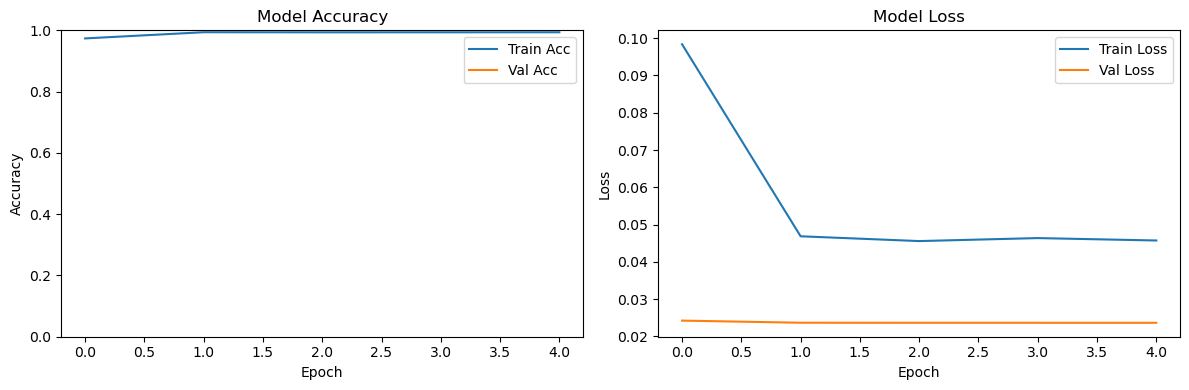

In [22]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Testing & Evaluating

In [24]:
# Load and preprocess test data
X_test, y_test = load_cross_test(folder_path=filenamepath_test,batch_size=BATCH_SIZE,downsample_step=DOWNSAMPLING_STEP,logs=1)

# One-hot encode labels
y_test = to_categorical(y_test, num_classes=4)

Loading from test1
X.shape from C:\Users\guill\Desktop\Uni\DeepLearning\Final Project data\Cross\test1: (23744, 3, 248)
Loading from test2
X.shape from C:\Users\guill\Desktop\Uni\DeepLearning\Final Project data\Cross\test2: (23744, 3, 248)
Loading from test3
X.shape from C:\Users\guill\Desktop\Uni\DeepLearning\Final Project data\Cross\test3: (23744, 3, 248)


In [25]:
[(0.715900182723999, [14, 100000, 0.00015, 0.98]), (0.7168548107147217, [12, 100000, 5e-05, 0.96]), (0.7189745903015137, [13, 100000, 5e-05, 0.92]), (0.7205188870429993, [14, 100000, 0.00015, 0.94]), (0.7219367623329163, [13, 100000, 5e-05, 0.98]), (0.7224982976913452, [14, 100000, 5e-05, 0.98]), (0.7247023582458496, [14, 100000, 0.0001, 0.94]), (0.7249410152435303, [13, 100000, 0.0001, 0.98]), (0.7268081903457642, [13, 100000, 5e-05, 0.94]), (0.7303038239479065, [14, 100000, 5e-05, 0.92]), (0.7378144860267639, [12, 100000, 0.00015, 0.98])]


[(0.715900182723999, [14, 100000, 0.00015, 0.98]),
 (0.7168548107147217, [12, 100000, 5e-05, 0.96]),
 (0.7189745903015137, [13, 100000, 5e-05, 0.92]),
 (0.7205188870429993, [14, 100000, 0.00015, 0.94]),
 (0.7219367623329163, [13, 100000, 5e-05, 0.98]),
 (0.7224982976913452, [14, 100000, 5e-05, 0.98]),
 (0.7247023582458496, [14, 100000, 0.0001, 0.94]),
 (0.7249410152435303, [13, 100000, 0.0001, 0.98]),
 (0.7268081903457642, [13, 100000, 5e-05, 0.94]),
 (0.7303038239479065, [14, 100000, 5e-05, 0.92]),
 (0.7378144860267639, [12, 100000, 0.00015, 0.98])]

In [26]:
# Evaluate
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

2226/2226 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8503 - loss: 5.9095
Test accuracy: 0.7253902554512024


In [27]:
# This piece of code collects all the instances that were predicted as 'motor' by the model in this notebook.
# Purpose: Since this model could improve on distinguishing motor and math, we could feed all predictions of 'motor' to a new model, for a second opinion
# So this code determines on what instances to ask a second opinion
X_second_op = []

counter = 0
while counter < len(y_test):
    if (list(y_test[counter])) == [0.0, 1.0, 0.0, 0.0]:
        # feed to other model
        instance = (X_test[counter])
        
        X_second_op.append(instance)

    counter = counter + 1

X_second_op = np.asarray(X_second_op)


2226/2226 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


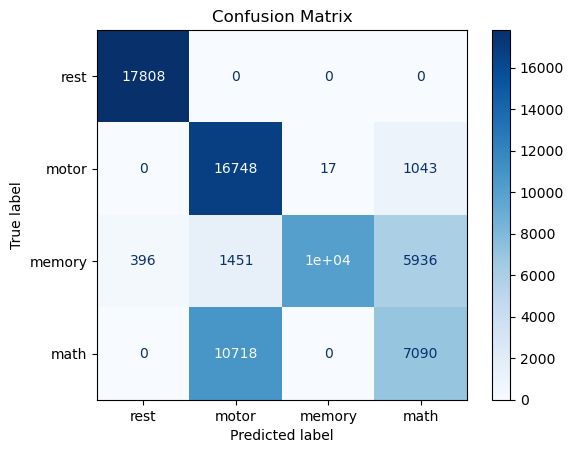

In [28]:

y_pred_probs = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rest", "motor", "memory", "math"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


1484/1484 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step
              precision    recall  f1-score   support

       motor       1.00      1.00      1.00     23744
        math       1.00      1.00      1.00     23744

    accuracy                           1.00     47488
   macro avg       1.00      1.00      1.00     47488
weighted avg       1.00      1.00      1.00     47488



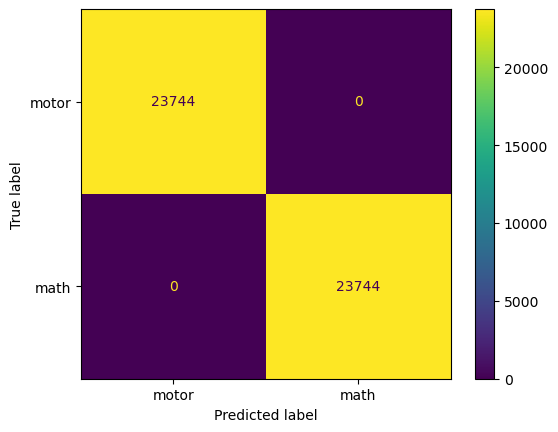

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_bin = (motor_math_model.predict(X_binary) > 0.5).astype(int)

print(classification_report(y_binary_labels, y_pred_bin, target_names=['motor', 'math']))

ConfusionMatrixDisplay(confusion_matrix(y_binary_labels, y_pred_bin), display_labels=['motor', 'math']).plot()


2226/2226 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
904/904 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step
Evaluation AFTER confidence-based refinement:
              precision    recall  f1-score   support

        rest       0.98      1.00      0.99     17808
       motor       0.56      0.88      0.68     17808
      memory       1.00      0.56      0.72     17808
        math       0.47      0.40      0.43     17808

    accuracy                           0.71     71232
   macro avg       0.75      0.71      0.71     71232
weighted avg       0.75      0.71      0.71     71232



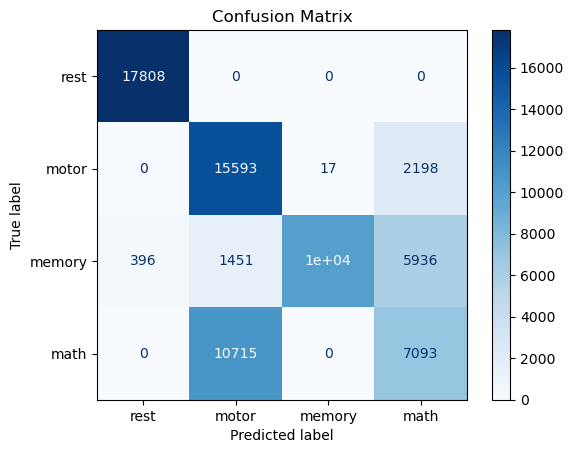

Test accuracy after refinement: 0.7092


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Step 1: Main model prediction
y_pred_main_probs = lstm_model.predict(X_test)
y_pred_main = np.argmax(y_pred_main_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step 2: Find motor predictions
motor_pred_indices = np.where(y_pred_main == 1)[0]
X_to_refine = X_test[motor_pred_indices]

# Step 3: Get binary model confidence scores
binary_conf = motor_math_model.predict(X_to_refine).ravel()  
confident_math = binary_conf > 0.8  

# Step 4: Apply only to confident overrides
refined_preds = y_pred_main.copy()
refined_preds[motor_pred_indices[confident_math]] = 3  

# Step 5: Evaluation
print("Evaluation AFTER confidence-based refinement:")
print(classification_report(y_true, refined_preds, target_names=["rest", "motor", "memory", "math"]))

plot=ConfusionMatrixDisplay(
    confusion_matrix(y_true, refined_preds),
    display_labels=["rest", "motor", "memory", "math"]
)
plot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 6: Accuracy
refined_accuracy = accuracy_score(y_true, refined_preds)
print(f"Test accuracy after refinement: {refined_accuracy:.4f}")


2226/2226 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
Evaluation AFTER memory refinement:
              precision    recall  f1-score   support

        rest       0.97      1.00      0.98     17808
       motor       0.57      0.94      0.71     17808
      memory       1.00      0.52      0.69     17808
        math       0.50      0.40      0.44     17808

    accuracy                           0.72     71232
   macro avg       0.76      0.72      0.71     71232
weighted avg       0.76      0.72      0.71     71232



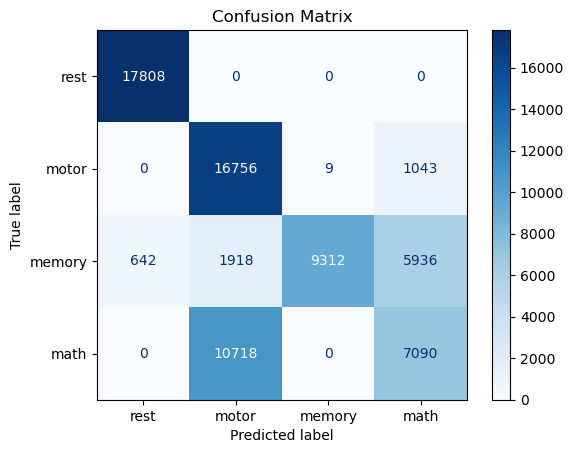

Test accuracy after refinement: 0.7155


In [42]:
# ==== SMART MEMORY REFINEMENT ====
y_pred_main_probs = lstm_model.predict(X_test)
y_pred_main = np.argmax(y_pred_main_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step A: Identify all samples predicted as 'memory' (label 2)
memory_pred_indices = np.where(y_pred_main == 2)[0]
X_mem_check = X_test[memory_pred_indices]

# Step B: Run binary memory model on them
mem_probs = memory_model.predict(X_mem_check).ravel()
not_memory = mem_probs < 0.2  

# Step C: Flip wrong memory predictions to most likely alternative
refined_preds = y_pred_main.copy()
alt_preds = np.argmax(np.delete(y_pred_main_probs[memory_pred_indices], 2, axis=1), axis=1)
refined_preds[memory_pred_indices[not_memory]] = alt_preds[not_memory] 


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

print("Evaluation AFTER memory refinement:")
print(classification_report(y_true, refined_preds, target_names=["rest", "motor", "memory", "math"]))

plotMemoryImprove=ConfusionMatrixDisplay(
    confusion_matrix(y_true, refined_preds),
    display_labels=["rest", "motor", "memory", "math"]
)
plotMemoryImprove.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

refined_accuracy = accuracy_score(y_true, refined_preds)
print(f"Test accuracy after refinement: {refined_accuracy:.4f}")


In [46]:
from sklearn.metrics import accuracy_score

refined_accuracy = accuracy_score(y_true, refined_preds)
print(f"Test accuracy after refinement: {refined_accuracy:.4f}")


Test accuracy after refinement: 0.7155
